# Modelling Solar generation across Multiple Sites - Part 1

This example shows how `timeserio` helps building deep learning models for time series forecasting. Especially,
we deal with the case of many related timeseries.

We demonstrate some core functionality and concepts, without striving for model accuracy or seeking out additional features like historic weather forecasts.

We will be using the dataset on solar (photo-voltaic, PV) generation potential across Europe, as collected by [SETIS](https://setis.ec.europa.eu/EMHIRES-datasets). The dataset presents solar generation, normalized to the solar capacity installed as of 2015.

## Download the data

In [1]:
!mkdir -p ~/tmp/datasets; cd ~/tmp/datasets; wget https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip; unzip -o EMHIRESPV_country_level.zip; rm EMHIRESPV_country_level.zip

--2019-07-10 10:14:11--  https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip
Resolving setis.ec.europa.eu (setis.ec.europa.eu)... 139.191.207.52
Connecting to setis.ec.europa.eu (setis.ec.europa.eu)|139.191.207.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93401258 (89M) [application/zip]
Saving to: ‘EMHIRESPV_country_level.zip’

EMHIRESPV_country_l 100%[===================>]  89.07M  4.15MB/s    in 17s     

2019-07-10 10:14:28 (5.16 MB/s) - ‘EMHIRESPV_country_level.zip’ saved [93401258/93401258]

Archive:  EMHIRESPV_country_level.zip
  inflating: EMHIRESPV_TSh_CF_Country_19862015.xlsx  


## Download data and save in a more performant format

In [2]:
import pandas as pd
import numpy as np

In [3]:
%%time
df = pd.read_excel("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015.xlsx")

CPU times: user 1min 32s, sys: 268 ms, total: 1min 33s
Wall time: 1min 33s


In [4]:
df.head(3)

,Time_step,Date,Year,Month,Day,Hour,AL,AT,BA,BE,...,NO,PL,PT,RO,RS,SI,SK,SE,XK,UK
0,1,1986-01-01 00:00:00,1986,1,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1986-01-01 01:00:00,1986,1,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1986-01-01 02:00:00,1986,1,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reshape data to tall format
We add a `country` column to identify each table row.

In [5]:
id_vars = ['Time_step', 'Date', 'Year', 'Month', 'Day', 'Hour']
country_vars = list(set(df.columns) - set(id_vars))
df_tall = pd.melt(df, id_vars=id_vars, value_vars=country_vars, var_name="country", value_name="generation")

### Store to parquet
[Apache Parquet](https://parquet.apache.org/documentation/latest/) is a much preferred data format for columnar numerical data - it is much faster to read (see below), is fully compatible with tools like `pandas` and Spark, and allows easy partitioning of large datasets.

In [6]:
%%time
df_tall.to_parquet("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015_tall.parquet")

CPU times: user 1.4 s, sys: 188 ms, total: 1.59 s
Wall time: 1.57 s


### Store to partitioned parquet

In [7]:
%%time
df_tall.to_parquet("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015_partitioned/", partition_cols=["country"])

CPU times: user 3.07 s, sys: 806 ms, total: 3.88 s
Wall time: 3.46 s


In [8]:
!tree -h --filelimit=10 ~/tmp/datasets

/home/igor/tmp/datasets
├── [4.0K]  EMHIRESPV_TSh_CF_Country_19862015_partitioned [35 entries exceeds filelimit, not opening dir]
├── [123M]  EMHIRESPV_TSh_CF_Country_19862015_tall.parquet
└── [ 95M]  EMHIRESPV_TSh_CF_Country_19862015.xlsx

1 directory, 2 files


## Load the data from parquet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%time
df = pd.read_parquet("/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015_tall.parquet")

CPU times: user 888 ms, sys: 542 ms, total: 1.43 s
Wall time: 395 ms


In [4]:
print(' '.join(sorted(df['country'].unique())))

AL AT BA BE BG CH CY CZ DE DK EE EL ES FI FR HR HU IE IT LT LU LV ME MK NL NO PL PT RO RS SE SI SK UK XK


In [5]:
plot_countries = ['ES', 'UK', 'FI', ]

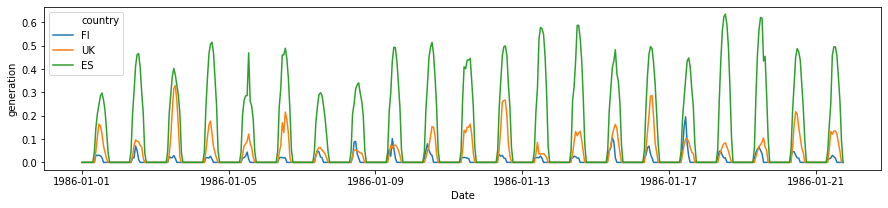

In [7]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df[(df['Time_step'] < 500) & (df['country'].isin(plot_countries))],
    x='Date', y='generation', hue='country',
)

In [6]:
df_monthly = df.groupby(['Month', 'country']).mean().reset_index()

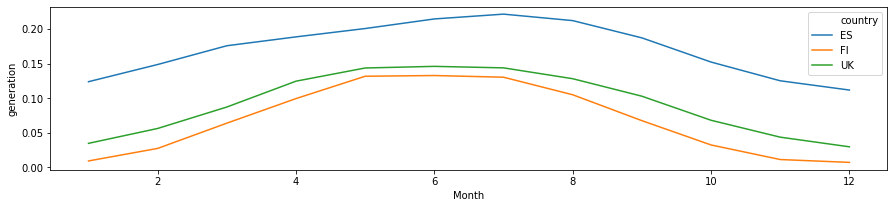

In [7]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_monthly[df_monthly['country'].isin(plot_countries)],
    x='Month', y='generation', hue='country',
)

In [8]:
df_daily = df.groupby(['Hour', 'country']).mean().reset_index()

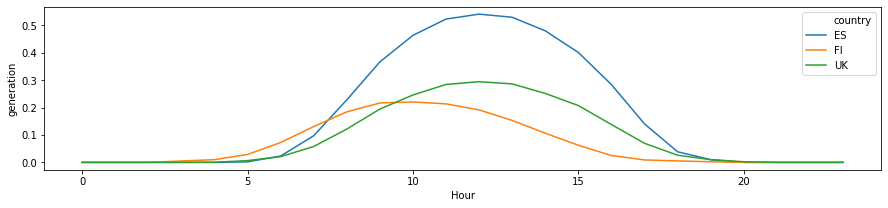

In [9]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_daily[df_daily['country'].isin(plot_countries)],
    x='Hour', y='generation', hue='country',
)

In [10]:
df_yearly = df.groupby(['Year', 'country']).mean().reset_index()

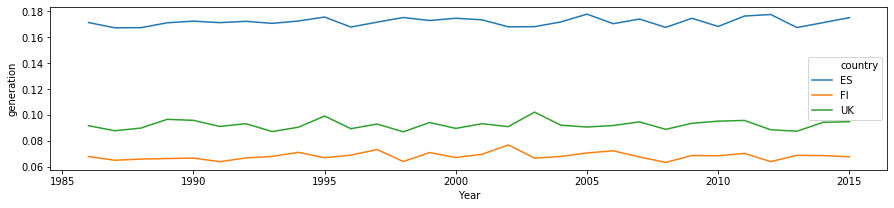

In [11]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    data=df_yearly[df_yearly['country'].isin(plot_countries)],
    x='Year', y='generation', hue='country',
)

### Preliminary observations

The timeseries for different countries exhibit a lot of similarity - they will have similar daily and seaonal shapes. At the same time, the curves have different scaling (due to latitudes and weather), and different time offsets (due to longitude). We can build models to incorporate these as external features, or learn the relevant features from the available data only!

## Split into train-test sets

In [44]:
df_dev = df.iloc[:100]
df_train, df_test = df[df['Year'] < 1995], df[df['Year'] >= 1995]
len(df_train), len(df_test)

(2761080, 6442800)

## Feature-based model with latent embeddings
For our first model, we use datetime and country as the only features.

To encode the datetime, we make use of periodic daily and yearly variables.

For each country, we learn an embedding, i.e. a latent representation, at training time.

### Define feature preprocessing
#### Datetime encoding using periodic features

In [9]:
from timeserio.pipeline import Pipeline
from timeserio.preprocessing import (
    PandasValueSelector, PandasDateTimeFeaturizer, StatelessPeriodicEncoder
)

periodic_pipe = Pipeline([
    ('select', PandasValueSelector(['dayofyear', 'fractionalhour'])),
    ('encode', StatelessPeriodicEncoder(n_features=2, periodic_features='all', period=[365, 24])),
])

datetime_pipeline = Pipeline([
    ('featurize_dt', PandasDateTimeFeaturizer(
        column='Date', attributes=['dayofyear', 'fractionalhour'])),
    ('encode', periodic_pipe)
])

#### Country label encoding
We convert countries to integer labels

In [24]:
from sklearn.preprocessing import OrdinalEncoder

In [49]:
country_list = sorted(df['country'].unique())
country_encoder = OrdinalEncoder(categories=[country_list])
country_encoder.categories_ = [country_list] # we can also call .fit()

country_pipeline = Pipeline([
    ('select', PandasValueSelector("country")),
    ('encode', country_encoder)
])

### Define the Neural Network Architecture

We define a regression network with two inputs: one for country feature, and one for datetime feature. It is easy to see how additional
inputs can be added. The output is our prediction for PV generation in a given time and place.

In [64]:
from timeserio.keras.multinetwork import MultiNetworkBase

from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.models import Model

class PVForecastingNetwork(MultiNetworkBase):
    def _model(
        self,
        location_dim=2, max_locations=100,  # embedding parameters
        num_features=4,  # number of real-valued features
        hidden_layers=2, hidden_units=8,  # any other parameters of the network
    ):
        loc_input = Input(shape=(1,), name='location')
        feature_input = Input(shape=(num_features,), name='features')
        loc_emb = Flatten()(Embedding(max_locations, location_dim, name='embed_location')(loc_input))
        output = Concatenate(name='concatenate')([loc_emb, feature_input])
        for idx in range(hidden_layers):
            output = Dense(hidden_units, activation='relu', name=f'dense_{idx}')(output)
        output = Dense(1, name='generation', activation='relu')(output)
        
        loc_model = Model(loc_input, loc_emb)
        forecasting_model = Model([loc_input, feature_input], output)
        forecasting_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
        
        return {'location': loc_model, 'forecast': forecasting_model}
    
multinetwork = PVForecastingNetwork()

### Connect feature pipelines to the neural network

Now, we combine feature pre-processing pipelines with the neural network(s) for an encapsulated, reusable model object.

In [65]:
from timeserio.pipeline import MultiPipeline

First we define a helper `MultiPipeline` object to keep all pipelines in one place.

In [66]:
multipipeline = MultiPipeline({
    "country": country_pipeline,
    "datetime": datetime_pipeline,
    "target": PandasValueSelector("generation")
})

Now we can refer to the pipelines by names, and associate them with inputs and outputs of the `keras` models defined in `PVForecastingNetwork`:

In [67]:
from timeserio.multimodel import MultiModel

manifold = {
    # keras_model_name: (input_pipes, output_pipes)
    "location": ("country", None),
    "forecast": (["country", "datetime"], "target")
}

multimodel = MultiModel(
    multinetwork=multinetwork,
    multipipeline=multipipeline,
    manifold=manifold
)

### Fit model from in-memory data

Having defined all details of our model in one place, fitting it is as simple as calling `.fit()` on a `keras` model:

```python
multimodel.fit(df_train, model="forecast", batch_size=2 ** 16, epochs=50, verbose=1)
```

We can also use aby batch generator - the pre-processing pipelines will be applied to each batch,
as long as the pipelines provide a `.transform` method:

```python
batchgen = RowBatchGenerator(
    df=df_train, batch_size=2**15,
    columns=['Date', "country", "generation"],
    id_column="country",
    batch_aggregator=3
)
multimodel.fit_generator(batchgen, model="forecast", epochs=50, verbose=1, workers=8)
```

In [68]:
multimodel.fit(
    df_train, model="forecast", batch_size=2 ** 16, epochs=50, verbose=1,
    validation_data=df_test
)

Train on 2761080 samples, validate on 6442800 samples
Epoch 1/50
2761080/2761080 [==============================] - 4s 2us/step - loss: 0.0769 - mean_absolute_error: 0.1930 - val_loss: 0.0563 - val_mean_absolute_error: 0.1471
Epoch 2/50
2761080/2761080 [==============================] - 4s 1us/step - loss: 0.0528 - mean_absolute_error: 0.1327 - val_loss: 0.0513 - val_mean_absolute_error: 0.1238
Epoch 3/50
2761080/2761080 [==============================] - 4s 1us/step - loss: 0.0512 - mean_absolute_error: 0.1227 - val_loss: 0.0511 - val_mean_absolute_error: 0.1211
Epoch 4/50
2761080/2761080 [==============================] - 4s 1us/step - loss: 0.0512 - mean_absolute_error: 0.1213 - val_loss: 0.0511 - val_mean_absolute_error: 0.1205
Epoch 5/50
2761080/2761080 [==============================] - 4s 1us/step - loss: 0.0511 - mean_absolute_error: 0.1210 - val_loss: 0.0511 - val_mean_absolute_error: 0.1203
Epoch 6/50
2761080/2761080 [==============================] - 4s 1us/step - loss: 0.05

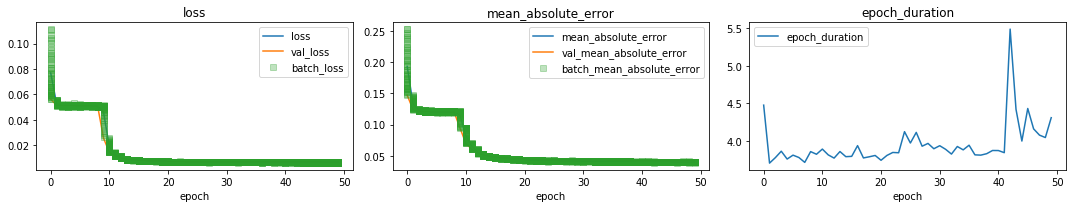

In [70]:
from kerashistoryplot.plot import plot_history
history = multimodel.history[-1]["history"]
plot_history(history, figsize=(15, 3), n_cols=3);

persist the model:

In [72]:
from timeserio.utils.pickle import loadf, dumpf
dumpf(multimodel, "/tmp/PV_model_1.pickle")

### Look at predictions

In [75]:
%%time
df_test["prediction"] = multimodel.predict(df_test, model="forecast", batch_size=2**16, verbose=1)

6442800/6442800 [==============================] - 1s 0us/step
CPU times: user 4.88 s, sys: 970 ms, total: 5.85 s
Wall time: 4.53 s


/home/igor/.pyenv/versions/3.6.4/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


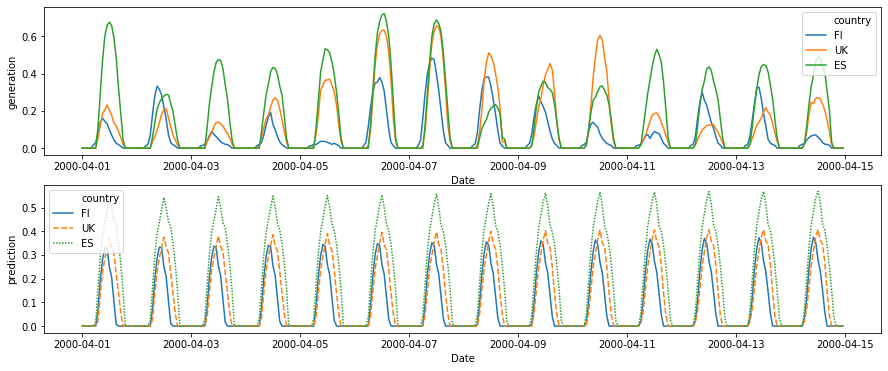

In [109]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 6))
df_plot = df_test[(df_test['Year'] == 2000) & (df_test['Month'] == 4) & (df_test['Day'] < 15) & (df_test['country'].isin(plot_countries))]

sns.lineplot(
    data=df_plot,
    x='Date', y='generation', hue='country',
    ax=axes[0]
)

sns.lineplot(
    data=df_plot,
    x='Date', y='prediction', hue='country',
    style='country',
    dashes=True,
    ax=axes[1]
)

In [103]:
df_monthly = df_test.groupby(['Month', 'country']).mean().reset_index()

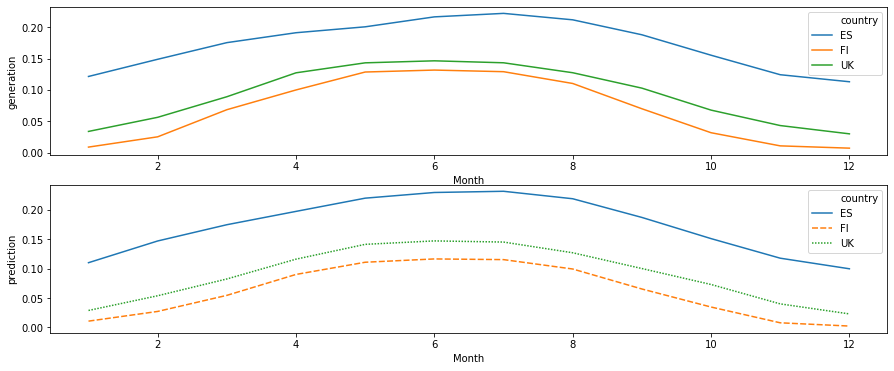

In [113]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 6))
sns.lineplot(
    data=df_monthly[df_monthly['country'].isin(plot_countries)],
    x='Month', y='generation', hue='country',
    ax=axes[0]
)
sns.lineplot(
    data=df_monthly[df_monthly['country'].isin(plot_countries)],
    x='Month', y='prediction', hue='country',
    style='country',
    dashes=True,
    ax=axes[1]
)

In [119]:
df_daily = df_test.groupby(['Hour', 'country']).mean().reset_index()

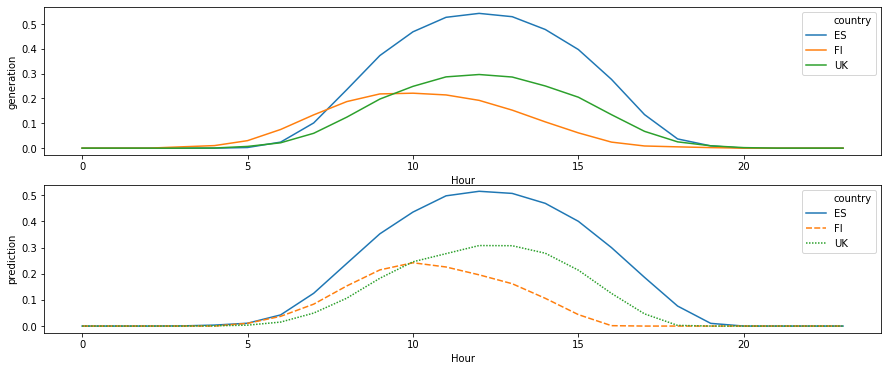

In [120]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 6))
sns.lineplot(
    data=df_daily[df_daily['country'].isin(plot_countries)],
    x='Hour', y='generation', hue='country',
    ax=axes[0]
)
sns.lineplot(
    data=df_daily[df_daily['country'].isin(plot_countries)],
    x='Hour', y='prediction', hue='country',
    style='country',
    dashes=True,
    ax=axes[1]
)

While our predictions do not capture short-range weather changes, they are excellent at seasonal level. Remember that all features such as location-specific scaling and time difference has been learned from the data!

### Inspect the country embedding variables
We can inspect what the model learned about individual countries by inspecting the individual embeddings using `multimodel`:

In [123]:
multimodel.model_names

['location', 'forecast']

In [144]:
country_df = df_test.groupby("country")['generation', 'prediction'].mean().reset_index()
country_df.head(3)

,country,generation,prediction
0,AL,0.167597,0.173074
1,AT,0.125796,0.126038
2,BA,0.134952,0.136902


In [167]:
embeddings = multimodel.predict(country_df, model="location")

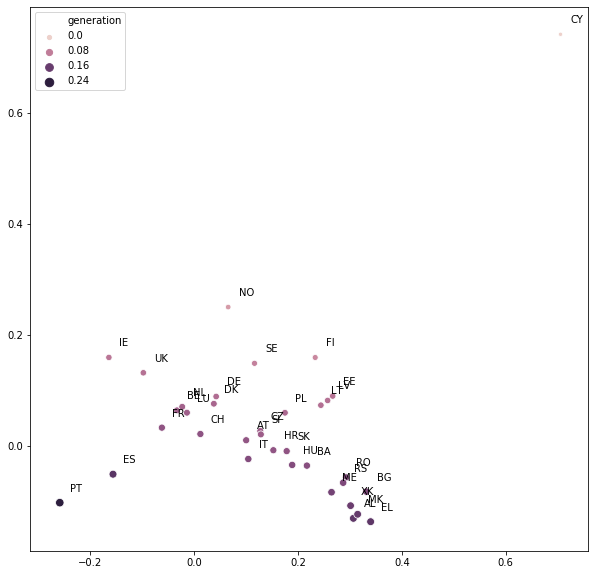

In [184]:
fig, ax = plt.subplots(figsize=(10, 10))
embeddings2 = np.dot(embeddings, [[0, 1], [-1, 0]])
sns.scatterplot(x=embeddings2[:, 0], y=embeddings2[:, 1], size="generation", hue="generation", data=country_df, ax=ax)
for country, embedding in zip(country_list, embeddings2):
    ax.annotate(country, xy=embedding, xytext=embedding + 0.02)

Note how similar the embeddings for *BE, NL, LU* and *LT, LV, EE* are! In fact, after a small (and arbitrary) rotation, we recover the map of Europe!

In this example, we have implemented a timeseries forecasting model using purely exogenous features, and made use of latent variables to capture the behaviour of multiple.